In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import re
import seaborn as sns
import numpy as np
import joypy
import datetime
from bokeh.plotting import figure, output_file, show
%matplotlib inline

In [2]:
routes=pd.read_csv(r"N:\Planning - New File Structure\GIS\Data\GTFS\VRT5_10_18\routes.txt")
routes=pd.DataFrame(routes)

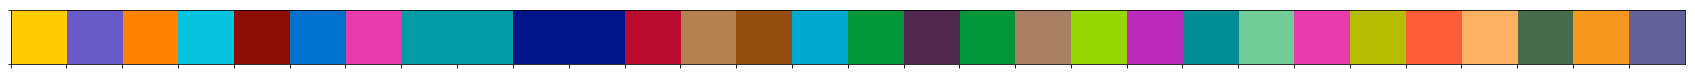

In [3]:
route_colors=sns.color_palette(routes['route_color'])
sns.palplot(route_colors)

In [4]:
OTP_data=pd.read_pickle(r"N:\Planning - New File Structure\Performance\OTP_FY18.pkl")

In [5]:
OTP_data['Relative']=OTP_data['DepartTime']-OTP_data['ScheduledStopTime']

In [6]:
OTP_data=OTP_data.dropna(subset=['DepartTime'])
OTP_data['Invalid']=np.logical_or(np.logical_or(OTP_data['Relative']>datetime.timedelta(hours=2),OTP_data['Relative']<datetime.timedelta(hours=1)),(OTP_data['DepartTime']<OTP_data['ArriveTime']))

In [7]:
OTP_data['Invalid']=np.logical_or(np.logical_or(OTP_data['Relative']>"02:00:00",OTP_data['Relative']<"-01:00:00"),(OTP_data['DepartTime']<OTP_data['ArriveTime']))

In [8]:
OTP_data=OTP_data[OTP_data.Invalid==False]

In [9]:
OTP_data.drop(['Invalid'],axis=1,inplace=True)

In [10]:
OTP_data['Early']=np.where(OTP_data['Relative']<"-00:01:00",True,False)

In [11]:
OTP_data['Late']=np.where(OTP_data['Relative']>"00:05:00",True,False)

In [12]:
OTP_data['OnTime']=np.logical_and(OTP_data['Early']==False,OTP_data['Late']==False)
OTP_data['Terminal']=np.where(np.logical_or(OTP_data['ScheduledTripStart']==OTP_data['ScheduledStopTime'],OTP_data['ScheduledTripEnd']==OTP_data['ScheduledStopTime']),True,False)

In [13]:
OTP_data['date']=OTP_data['ScheduledStopTime'].dt.date
OTP_data['time']=OTP_data['ScheduledStopTime'].dt.time
OTP_data['hour']=[r.hour for r in OTP_data.time]
OTP_data['RelNum']=(pd.to_numeric(OTP_data['Relative'],downcast='integer'))/60000000000

In [14]:
by_route=OTP_data.groupby(['MasterRouteName','hour'])

In [15]:
by_route_early=by_route.Early.sum()
by_route_ontime=by_route.OnTime.sum()
by_route_late=by_route.Late.sum()
by_route_df=pd.DataFrame([by_route_early,by_route_ontime,by_route_late]).T

In [16]:
cols=['Early','OnTime','Late']
by_route_df['Early_pct']=(by_route_df['Early']/by_route_df[cols].sum(axis=1))*100
by_route_df['OnTime_pct']=(by_route_df['OnTime']/by_route_df[cols].sum(axis=1))*100
by_route_df['Late_pct']=(by_route_df['Late']/by_route_df[cols].sum(axis=1))*100

In [17]:
by_route_df.reset_index(inplace=True)

In [18]:
heat=by_route_df.pivot("hour","MasterRouteName","OnTime_pct")
ridge=by_route_df.pivot("MasterRouteName","hour","OnTime_pct")

In [19]:
heat.head()

MasterRouteName,Route 1 Parkcenter,Route 10 Hill Road,Route 11 Garden City,Route 12 Maple Grove,Route 14 Hyde Park,Route 16 VA Shuttle,Route 17 Warm Springs,Route 18 Harris Ranch,Route 2 Broadway,Route 28 Cole / Victory,...,Route 53 Nampa North,Route 54 Caldwell South,Route 55 CWI Shuttle,Route 6 Orchard,Route 7A Fairview Ustick,Route 7B Fairview - Towne Square Mall,Route 8 Five Mile,Route 8x Five Mile Chinden,Route 9 State Street,Route 9x State Street
hour,,,,,,,,,,,,,,,,,,,,,
5,85.833333,89.361702,NaN,68.406072,95.180723,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,52.806122,70.430108,NaN,NaN,82.004234,NaN
6,69.923126,87.932251,NaN,85.513421,79.399468,73.022152,95.619524,82.926829,89.171975,NaN,...,76.119403,66.666667,NaN,71.665642,52.285319,75.000000,87.500000,64.609236,79.543358,82.295082
7,51.708801,78.819444,NaN,58.333333,75.961180,44.444444,75.019889,74.654378,74.789170,60.050891,...,73.650794,76.066351,52.789700,47.370471,30.875123,57.692308,50.577664,53.120506,74.711111,79.244424
8,53.320817,71.673820,NaN,55.853132,73.987854,43.780291,74.577635,76.298701,64.786526,65.336658,...,68.649518,60.321101,60.495283,60.586735,25.950413,54.437589,25.965178,22.435021,71.010860,82.091821
9,43.561763,76.109091,93.345656,61.019164,71.364452,37.991968,76.390008,NaN,76.507686,72.822823,...,58.088235,82.621951,57.159763,52.856246,31.211954,56.846673,59.162896,NaN,72.488441,NaN


In [20]:
ridge.head()

hour,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
MasterRouteName,,,,,,,,,,,,,,,,,,
Route 1 Parkcenter,85.833333,69.923126,51.708801,53.320817,43.561763,51.720795,49.975810,43.201543,45.437352,51.172810,46.053602,44.223870,42.256309,52.496038,NaN,NaN,NaN,NaN
Route 10 Hill Road,89.361702,87.932251,78.819444,71.673820,76.109091,80.028839,76.214834,62.695089,63.161820,56.173977,38.831741,28.960119,28.898051,45.715409,56.100051,NaN,NaN,NaN
Route 11 Garden City,NaN,NaN,NaN,NaN,93.345656,68.076616,76.504065,70.540098,68.637110,68.149325,50.909091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Route 12 Maple Grove,68.406072,85.513421,58.333333,55.853132,61.019164,61.085343,53.762030,50.000000,40.283311,40.254052,21.524064,21.062026,15.563670,42.496357,57.917019,NaN,NaN,NaN
Route 14 Hyde Park,95.180723,79.399468,75.961180,73.987854,71.364452,73.795872,73.165003,78.172293,66.492451,71.519353,69.285999,74.449036,68.024963,70.437956,NaN,NaN,NaN,NaN


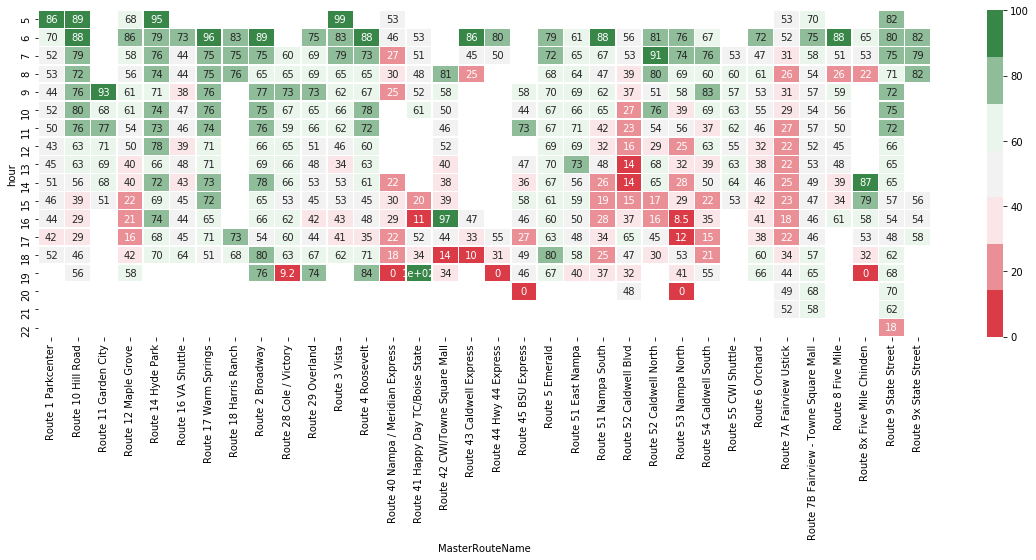

In [21]:
f, ax=plt.subplots(figsize=(20,6))
sns.heatmap(heat, annot=True,linewidths=.5,ax=ax,cmap=sns.diverging_palette(10,133,sep=80,n=7))

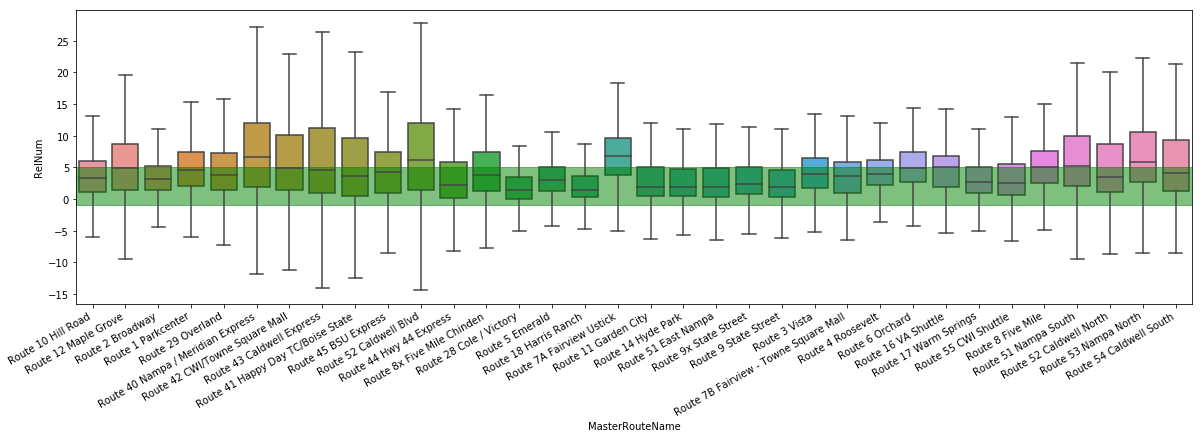

In [22]:
fig, ax=plt.subplots(figsize=(20,6))
sns.boxplot(x=OTP_data.MasterRouteName,y=OTP_data.RelNum,ax=ax,showfliers=False)
plt.yticks(np.arange(-15, 35, step=5))
plt.axhspan(-1,5,color='green',alpha=.5)
fig.autofmt_xdate()

C:\Users\bparker\AppData\Local\conda\conda\envs\mappingPy3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


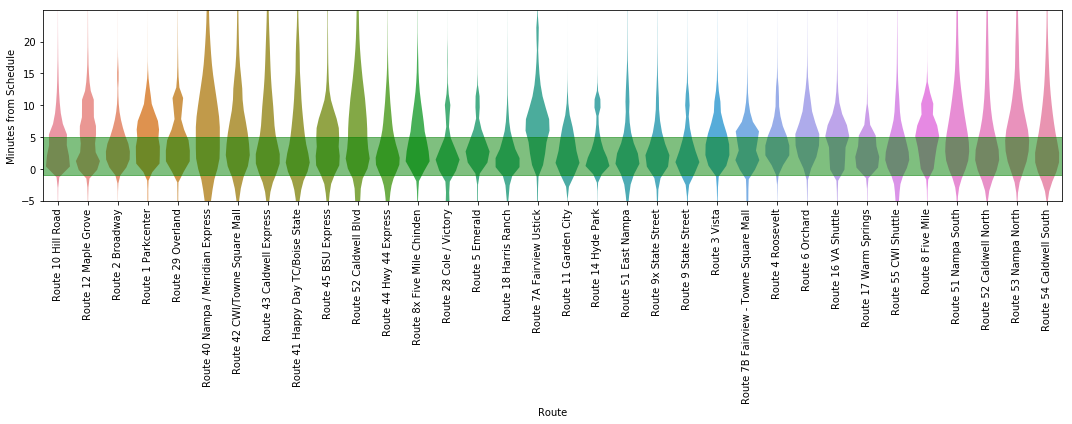

In [23]:
f, ax = plt.subplots(figsize=(15,6))
violin=sns.violinplot(x=OTP_data.MasterRouteName,y=OTP_data.RelNum,ax=ax,scale="width",linewidth=0)
plt.xticks(rotation=90)
plt.yticks(np.arange(-5, 25, step=5))
plt.ylim(-5,25)
plt.ylabel("Minutes from Schedule")
plt.xlabel("Route")
plt.axhspan(-1,5,color='green',alpha=.5)
plt.tight_layout()

In [24]:
OTP_data.set_index("MasterRouteName",inplace=True)
OTP_data.loc['Route 40 Nampa / Meridian Express']

,TripName,StopName,DriverName,TripDate,ScheduledTripStart,ScheduledTripEnd,StopOrder,ScheduledStopTime,ArriveTime,DepartTime,Relative,Early,Late,OnTime,Terminal,date,time,hour,RelNum
MasterRouteName,,,,,,,,,,,,,,,,,,,
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,Happy Day Transit Center,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,1,2018-02-14 15:10:00,2018-02-14 15:06:19,2018-02-14 15:06:20,-1 days +23:56:20,True,False,False,True,2018-02-14,15:10:00,15,-3.666667
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,CWI Park & Ride,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,7,2018-02-14 15:33:00,2018-02-14 15:39:24,2018-02-14 15:40:09,00:07:09,False,True,False,False,2018-02-14,15:33:00,15,7.150000
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,Overland @ Black Marlin,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,10,2018-02-14 15:44:00,2018-02-14 15:54:53,2018-02-14 15:55:06,00:11:06,False,True,False,False,2018-02-14,15:44:00,15,11.100000
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,Main & 8th,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,12,2018-02-14 16:06:00,2018-02-14 16:11:46,2018-02-14 16:12:26,00:06:26,False,True,False,False,2018-02-14,16:06:00,16,6.433333
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,Main & 1st,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,14,2018-02-14 16:10:00,2018-02-14 16:14:21,2018-02-14 16:14:42,00:04:42,False,False,True,False,2018-02-14,16:10:00,16,4.700000
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,University @ BSU Admin Bldg.,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,19,2018-02-14 16:17:00,2018-02-14 16:21:03,2018-02-14 16:29:50,00:12:50,False,True,False,False,2018-02-14,16:17:00,16,12.833333
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,University & Joyce,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,20,2018-02-14 16:24:00,2018-02-14 16:20:23,2018-02-14 16:30:44,00:06:44,False,True,False,True,2018-02-14,16:24:00,16,6.733333
Route 40 Nampa / Meridian Express,R40_16:25_Weekday_70331,University & Joyce,Chris Kremp,2018-02-14,2018-02-14 16:25:00,2018-02-14 17:30:00,1,2018-02-14 16:25:00,2018-02-14 16:20:23,2018-02-14 16:29:13,00:04:13,False,False,True,True,2018-02-14,16:25:00,16,4.216667
Route 40 Nampa / Meridian Express,R40_16:25_Weekday_70331,Idaho & 1st,Chris Kremp,2018-02-14,2018-02-14 16:25:00,2018-02-14 17:30:00,5,2018-02-14 16:32:00,2018-02-14 16:37:38,2018-02-14 16:38:01,00:06:01,False,True,False,False,2018-02-14,16:32:00,16,6.016667


In [25]:
forty=OTP_data.loc['Route 40 Nampa / Meridian Express']
forty=forty.groupby(['StopName','hour'])

In [26]:
forty_early=forty.Early.sum()
forty_ontime=forty.OnTime.sum()
forty_late=forty.Late.sum()
forty_df=pd.DataFrame([forty_early,forty_ontime,forty_late]).T

In [27]:
cols=['Early','OnTime','Late']
forty_df['Early_pct']=(forty_df['Early']/forty_df[cols].sum(axis=1))*100
forty_df['OnTime_pct']=(forty_df['OnTime']/forty_df[cols].sum(axis=1))*100
forty_df['Late_pct']=(forty_df['Late']/forty_df[cols].sum(axis=1))*100

forty_df.reset_index(inplace=True)

heat40=forty_df.pivot("hour","StopName","OnTime_pct")
ridge40=forty_df.pivot("StopName","hour","OnTime_pct")

In [28]:
heat40.head()

StopName,CWI Park & Ride,Happy Day Transit Center,Idaho & 1st,Idaho & 9th,Main & 1st,Main & 8th,Overland @ Black Marlin,University & Joyce,University & Joyce OB,University @ BSU Admin Bldg.
hour,,,,,,,,,,
5,74.576271,41.902314,NaN,NaN,NaN,NaN,54.878049,NaN,NaN,NaN
6,56.786704,51.294118,NaN,NaN,39.959016,50.819672,44.672131,22.222222,NaN,29.816514
7,46.779661,NaN,38.492872,38.775510,22.379032,17.444219,26.747312,29.327902,0.0,7.186858
8,26.966292,32.900433,25.200000,31.726908,0.000000,NaN,41.818182,31.629393,0.0,4.471545
9,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


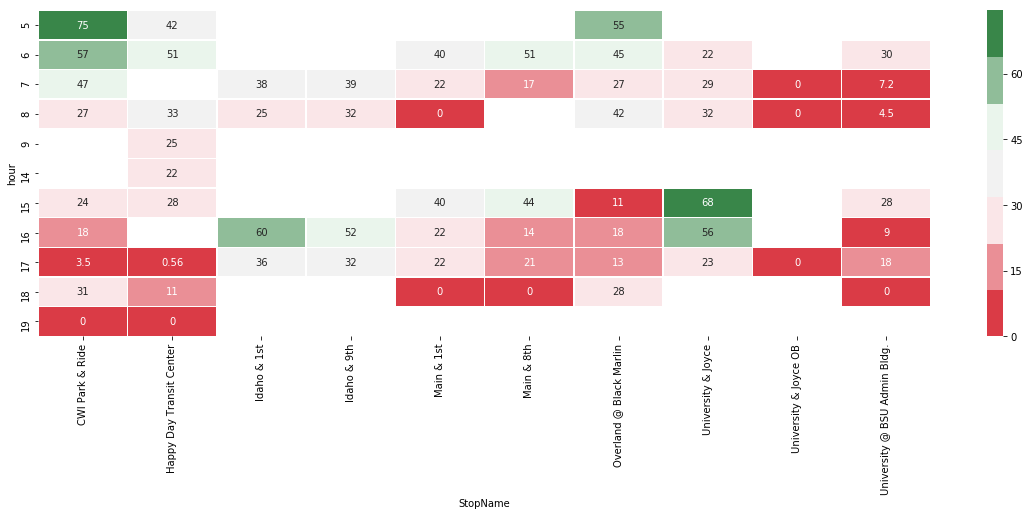

In [29]:
f, ax=plt.subplots(figsize=(20,6))
sns.heatmap(heat40, annot=True,linewidths=.5,ax=ax,cmap=sns.diverging_palette(10,133,sep=80,n=7))

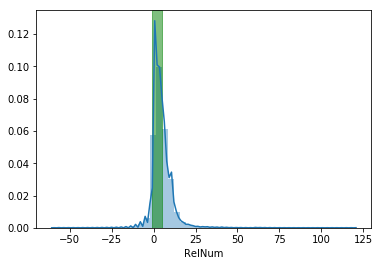

In [30]:
sns.distplot(OTP_data['RelNum'])
plt.axvspan(-1,5,color='green',alpha=.5)

In [31]:
OTP_data.RelNum.describe()

count    797394.000000
mean          4.661485
std           6.565160
min         -60.000000
25%           1.216667
50%           3.616667
75%           6.783333
max         119.883333
Name: RelNum, dtype: float64

In [32]:
forty.head()

,TripName,StopName,DriverName,TripDate,ScheduledTripStart,ScheduledTripEnd,StopOrder,ScheduledStopTime,ArriveTime,DepartTime,Relative,Early,Late,OnTime,Terminal,date,time,hour,RelNum
MasterRouteName,,,,,,,,,,,,,,,,,,,
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,Happy Day Transit Center,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,1,2018-02-14 15:10:00,2018-02-14 15:06:19,2018-02-14 15:06:20,-1 days +23:56:20,True,False,False,True,2018-02-14,15:10:00,15,-3.666667
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,CWI Park & Ride,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,7,2018-02-14 15:33:00,2018-02-14 15:39:24,2018-02-14 15:40:09,00:07:09,False,True,False,False,2018-02-14,15:33:00,15,7.150000
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,Overland @ Black Marlin,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,10,2018-02-14 15:44:00,2018-02-14 15:54:53,2018-02-14 15:55:06,00:11:06,False,True,False,False,2018-02-14,15:44:00,15,11.100000
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,Main & 8th,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,12,2018-02-14 16:06:00,2018-02-14 16:11:46,2018-02-14 16:12:26,00:06:26,False,True,False,False,2018-02-14,16:06:00,16,6.433333
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,Main & 1st,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,14,2018-02-14 16:10:00,2018-02-14 16:14:21,2018-02-14 16:14:42,00:04:42,False,False,True,False,2018-02-14,16:10:00,16,4.700000
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,University @ BSU Admin Bldg.,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,19,2018-02-14 16:17:00,2018-02-14 16:21:03,2018-02-14 16:29:50,00:12:50,False,True,False,False,2018-02-14,16:17:00,16,12.833333
Route 40 Nampa / Meridian Express,R40_15:10_Weekday_70339,University & Joyce,Chris Kremp,2018-02-14,2018-02-14 15:10:00,2018-02-14 16:24:00,20,2018-02-14 16:24:00,2018-02-14 16:20:23,2018-02-14 16:30:44,00:06:44,False,True,False,True,2018-02-14,16:24:00,16,6.733333
Route 40 Nampa / Meridian Express,R40_16:25_Weekday_70331,University & Joyce,Chris Kremp,2018-02-14,2018-02-14 16:25:00,2018-02-14 17:30:00,1,2018-02-14 16:25:00,2018-02-14 16:20:23,2018-02-14 16:29:13,00:04:13,False,False,True,True,2018-02-14,16:25:00,16,4.216667
Route 40 Nampa / Meridian Express,R40_16:25_Weekday_70331,Idaho & 1st,Chris Kremp,2018-02-14,2018-02-14 16:25:00,2018-02-14 17:30:00,5,2018-02-14 16:32:00,2018-02-14 16:37:38,2018-02-14 16:38:01,00:06:01,False,True,False,False,2018-02-14,16:32:00,16,6.016667


In [33]:
violin.figure.savefig(r"N:\Planning - New File Structure\Performance\Annual Report\VRT_ontime_violin.png")